In [6]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

In [7]:
import template_funciones
import importlib
importlib.reload(template_funciones)

<module 'template_funciones' from 'C:\\Users\\Juliana\\Desktop\\ALC\\TP-Museos-ALC\\template_funciones.py'>

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [12]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

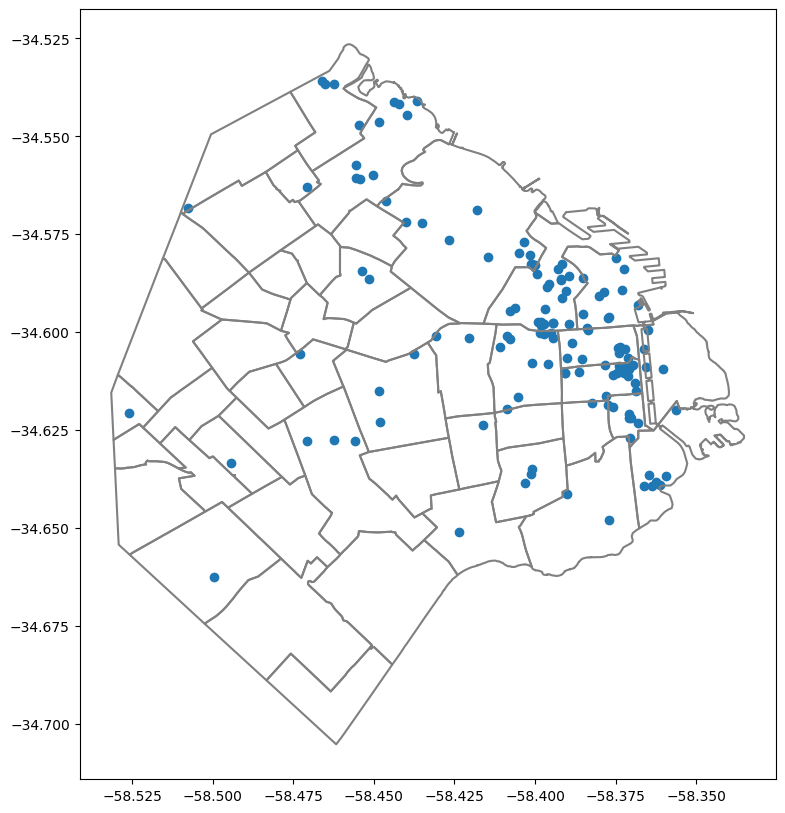

In [ ]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [14]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [16]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)
print (A)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

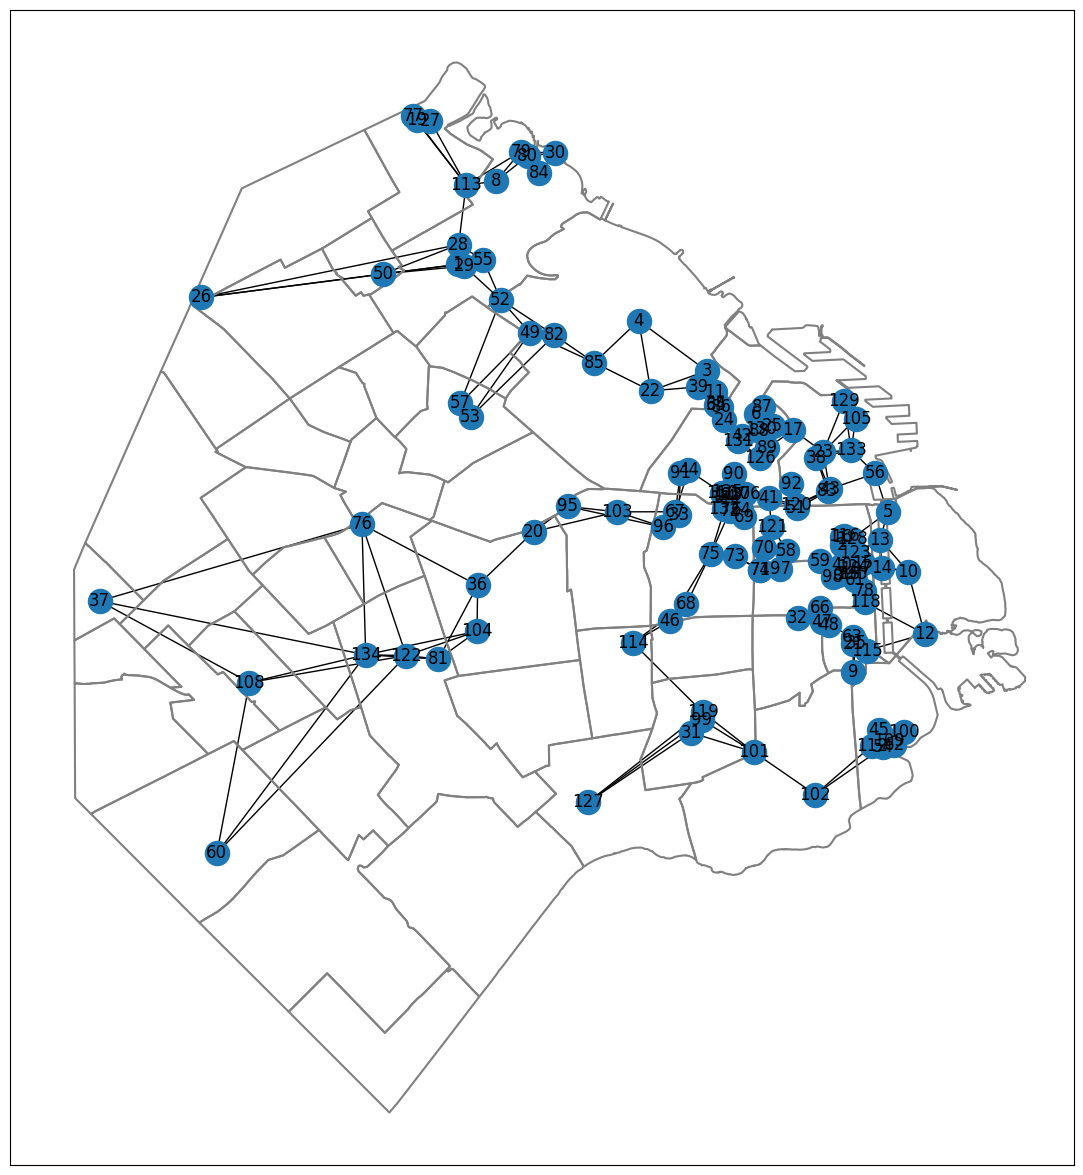

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

Como primer acercamiento al trabajo, experimentamos variando el valor de $m$ en la matriz de adyacencia $A$ y observamos como varia el gráfico. Si bien con un $m$ = 5 los museos periféricos están lo suficientemente conectadas con el resto del mapa, llegamos a la conclusión de que para todo $m \geq 48$ se produce una conexión directa entre todas las zonas de la periferia sin tener que pasar por el centro. Esto implica que, a pesar de estar en un mismo territorio, la distancia afecta fuertemente la relación entre los museos, y aquellos que están muy alejados tienen baja probabilidad de ser visitados en comparación con museos más centrales.

## Punto 1:


Partimos de la ecucacion 3, sabiendo que ${\alpha} > 0 \ y\ N > 0 $ :

\begin{align*}
 p = (1 - \alpha) C p + \frac{\alpha}{N} \mathbf{1} \\
p - (1 - \alpha) C p = \frac{\alpha}{N} \mathbf{1} \\
p \ast (\mathbf{I} - (1 - \alpha) C) = \frac{\alpha}{N} \mathbf{1} &\rightarrow \text{sacamos factor común p} \\
\frac{N}{\alpha}(\mathbf{I} - (1 - \alpha) C)\ast p = \mathbf{1} \\
\end{align*}

$
\therefore \boxed{\frac{N}{\alpha}(\mathbf{I} - (1 - \alpha) C)\ast p = \mathbf{1} \;\text{para} \; \alpha > 0}
$ \\
\
$
\text{caso} \;{\alpha} = 0 \ y\ N > 0 : \\
\frac{N}{\alpha}(\mathbf{I} - (1 - \alpha) C)\ast p = \mathbf{1} \\
\frac{N}{\alpha}\; \text{es una indeterminación} \\
\therefore \boxed{\text{para} \ {\alpha = 0} \ \text{no hay solución} }
$

## Punto 2:
Queremos probar que existe una solución única a la ecuación $Mp = b$. En otras palabras, queremos ver que este sistema es compatible determinado. Para ello, $M$ debe ser inversible. Por consiguiente, el determinante de $M$ debe ser distinto de $0$, que es lo mismo que pedir que su rango sea igual a la dimensión de $M$, es decir, $rango(M) = N$.

 Para abordar esto, vamos a analizar primero los casos bordes. Empezamos evaluando qué ocurre cuando $\alpha = 1$ y $\alpha = 0$, para luego extender el análisis al intervalo intermedio. Esto nos va a permitir entender mejor bajo qué condiciones se garantiza la existencia de una única solución.

Caso $\alpha = 1$:
$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha)C \right) $$
$$ M = \frac{N}{1} \left( I - (1 - 1)C \right) $$
$$ M = N(I - 0 * C) $$
$$ \boxed{M = N * I} $$

Por otro lado:
$$ \mathbf{p} = (1 - \alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1} $$
$$ \mathbf{p} = (1 - 1) C \mathbf{p} + \frac{1}{N} \mathbf{1} $$
$$ \mathbf{p} = 0 \cdot C \mathbf{p} + \frac{1}{N} \mathbf{1} $$
$$ \boxed{\mathbf{p} = \frac{1}{N} \mathbf{1}} $$


Reemplazando en la ecuación $M\mathbf{p} = \mathbf{b}$:
$$ (N * I) \left( \frac{1}{N} \mathbf{1}\right) = \mathbf{1} $$
$$ I * \mathbf{1} = \mathbf{1} $$
$$ \boxed{\mathbf{1} = \mathbf{1}} $$
$\therefore$ Para $\alpha = 1$, $M\mathbf{p} = \mathbf{b}$. \\
$M$ es la matriz identidad multiplicada por un escalar, entonces es invertible. Por lo tanto, el sistema tiene solución única.

Caso $\alpha = 0$:
$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha)C \right) $$
es una indeterminación por $\frac{N}{0}$. \\
$\therefore$ Para $\alpha = 0$, $M\mathbf{p} = \mathbf{b}$ no tiene solución.

Caso $0 < \alpha < 1$:
Necesitamos que $M$ sea invertible.
$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha)C \right) $$
Definimos la matriz $A$ ya que el producto por el escalar $\frac{N}{\alpha}$ no afecta la invertibilidad de $M$\
$$ A = \left( I - (1 - \alpha)C \right) $$
Si $Det(A) \neq 0$ se cumple que $M$ es invertible.
Sabemos que la diagonal de $C$ está compuesta por todos $0$, ya que se construye a partir de la matriz de adyacencia. Entonces, en la diagonal de $(1 - \alpha)C$ también ocurre lo mismo. Por lo tanto $A= \left( I - (1 - \alpha)C \right) $ va a tener todos $1$ en su diagonal. El producto de los números de la diagonal de $A$ es distinto de $0$ aunque esto no basta para decir que el $Det(A)$ es distinto de $0$ porque carecemos de información acerca de los números bajo la diagonal (no sabemos si $A$ está escalonada). \\
Buscamos demostrar por otro lado, usando el rango de la matriz $M$. \\
Por el enunciado la dimension de $M$ es $N$.
Para que el sistema tenga solución única necesitamos que el $rango(M) = N$. \\
Sabemos que $rango(M) = dim(Im(M))$ \\
Por el teorema de la dimensión vale: $dim(M) = dim(Im(M)) + dim(Nu(M))$.

Por lo tanto:
$$
\begin{array}{l}
dim(M) = rango(M) + dim(Nu(M)) \\
N = N + dim(Nu(M)) \\
\boxed{dim(Nu(M)) = 0}
\\
\end{array}
$$

$M$ es INVERTIBLE $\iff Nu(M) = \{0\}$. \\
$\therefore$ Para que el sistema $M\mathbf{p} = \mathbf{b} \;con\; 0 < \alpha < 1$, tenga solución única la condicion es que el  $Nu(M) = \{0\}$.

#Punto 3:
###3a).1 Caso m y $\alpha$ fijos:

Calcularemos el PageRank con $m=3$ (los 3 vecinos más cercanos) y un factor de amortiguación $\alpha = \tfrac{1}{5}$. El vector de PageRank se obtiene resolviendo el sistema:

$ M \, p = b $

donde $M$ es la matriz de transición y $b$ es un vector de unos. Luego, visualizaremos la importancia de cada nodo (museo) de acuerdo con su valor en $p$.

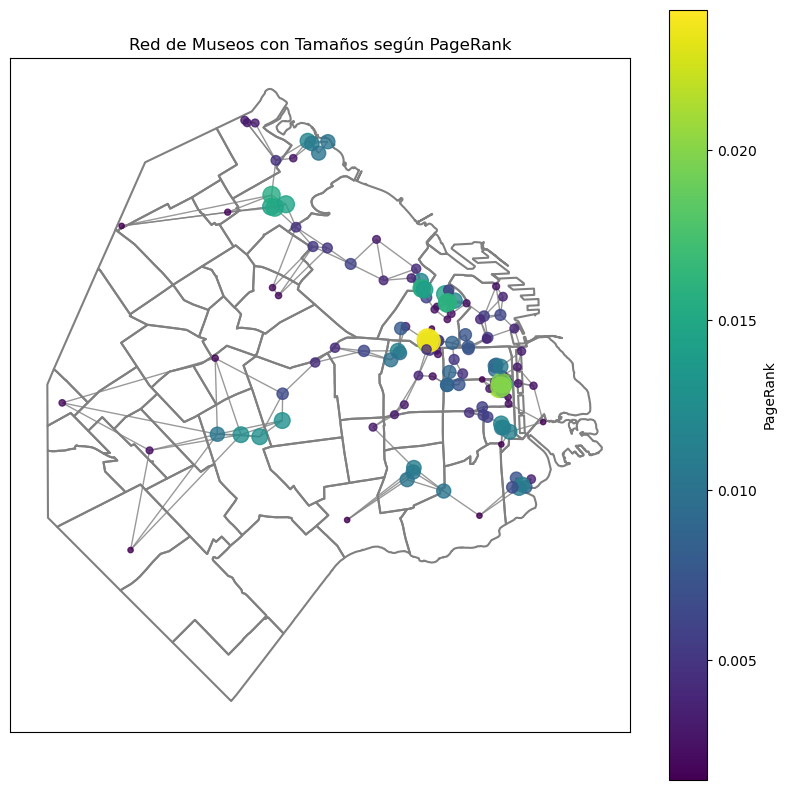

In [18]:
template_funciones.ejercicio_3_a(D)

+ La zona con más concentración de nodos grandes está en el noreste del mapa, esto sugiere que en esa región se encuentra el núcleo más importante de la red de museos

+ En los extremos del mapa (especialmente al sur y oeste), los nodos son pequeños y oscuros, indicando que esos museos tienen bajo pageRank y podrían estar más aislados o con menos visitas.

+ La red posee una distribución mayormente uniforme en todo el territorio, pero vemos claros puntos centrales que destacan en distintas zonas (nodos más claros y grandes).

+ Las zonas donde se pueden ver los museos con mejor PageRank son Recoleta donde se encuentran entre otros, el museo de Farmacobotanica, Montserrat, donde se ubica el Museo de la Ciudad y Belgrano.

### 3b).1 Variación de $m$

Repetiremos el cálculo para diferentes valores de $m$ : rango_m = \{1, 3, 5, 10\}  
Mantendremos constante el valor de $\alpha = \tfrac{1}{5}$ y observaremos cómo cambia la estructura de la red y la distribución de importancia de los nodos a medida que varía el número de vecinos considerados.

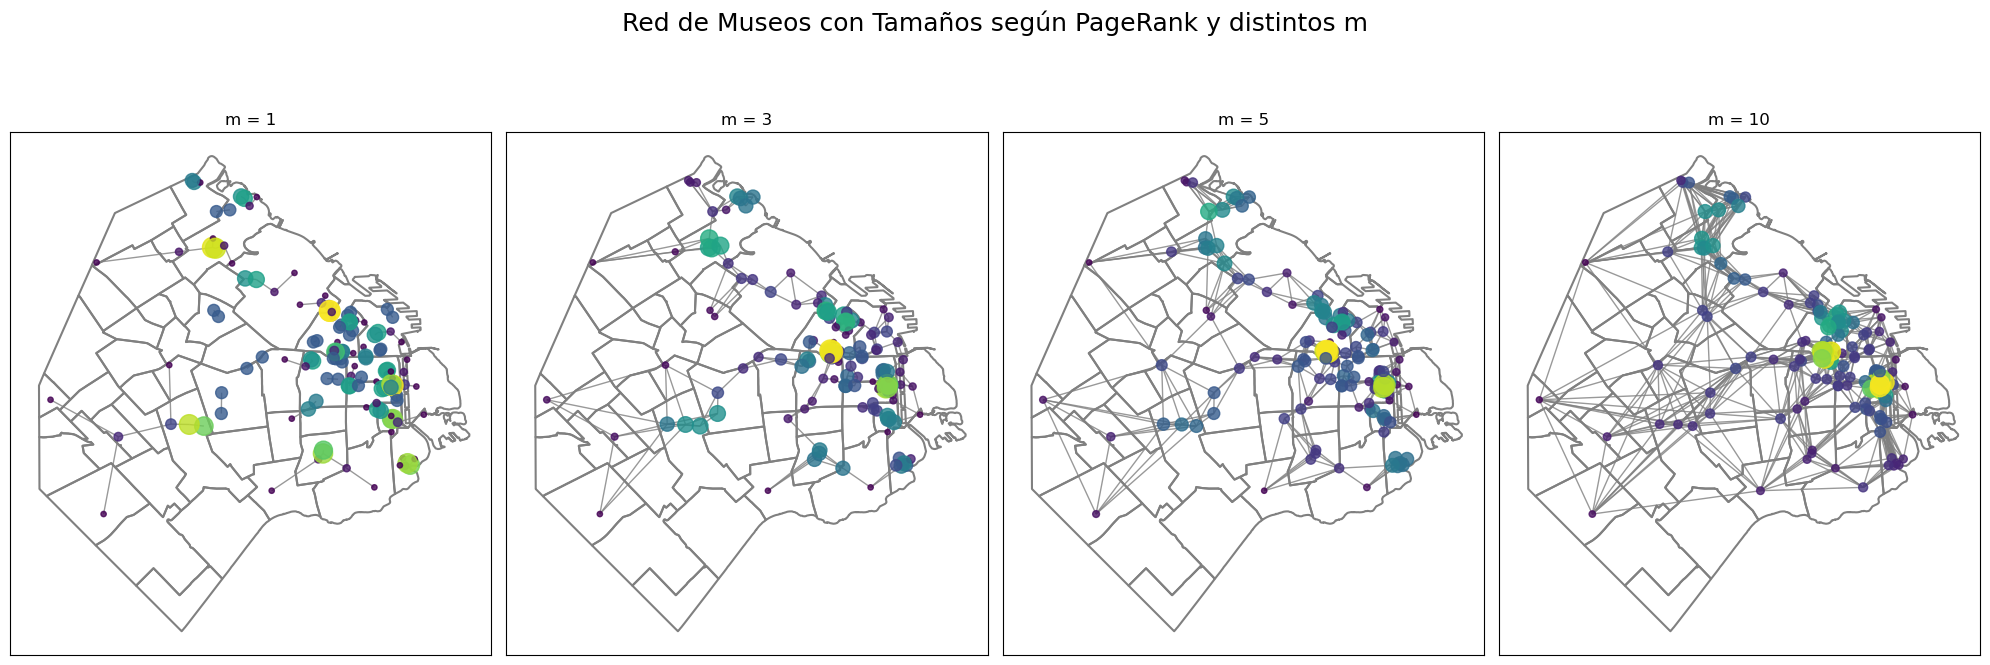

In [20]:
alpha = 1/5
rango_m = [1,3,5,10]
template_funciones.ejercicio_3_b(D, alpha, rango_m)

### 3c).1 Variación de $\alpha$

Con $m=5$ fijo, analizaremos el impacto de diferentes factores de amortiguación:  
$\alpha = \left\{ \tfrac{6}{7}, \tfrac{4}{5}, \tfrac{2}{3}, \tfrac{1}{2}, \tfrac{1}{3}, \tfrac{1}{5}, \tfrac{1}{7} \right\}$.

Veremos cómo el valor de $\alpha$ afecta la convergencia del algoritmo y la distribución final del ranking de los nodos.

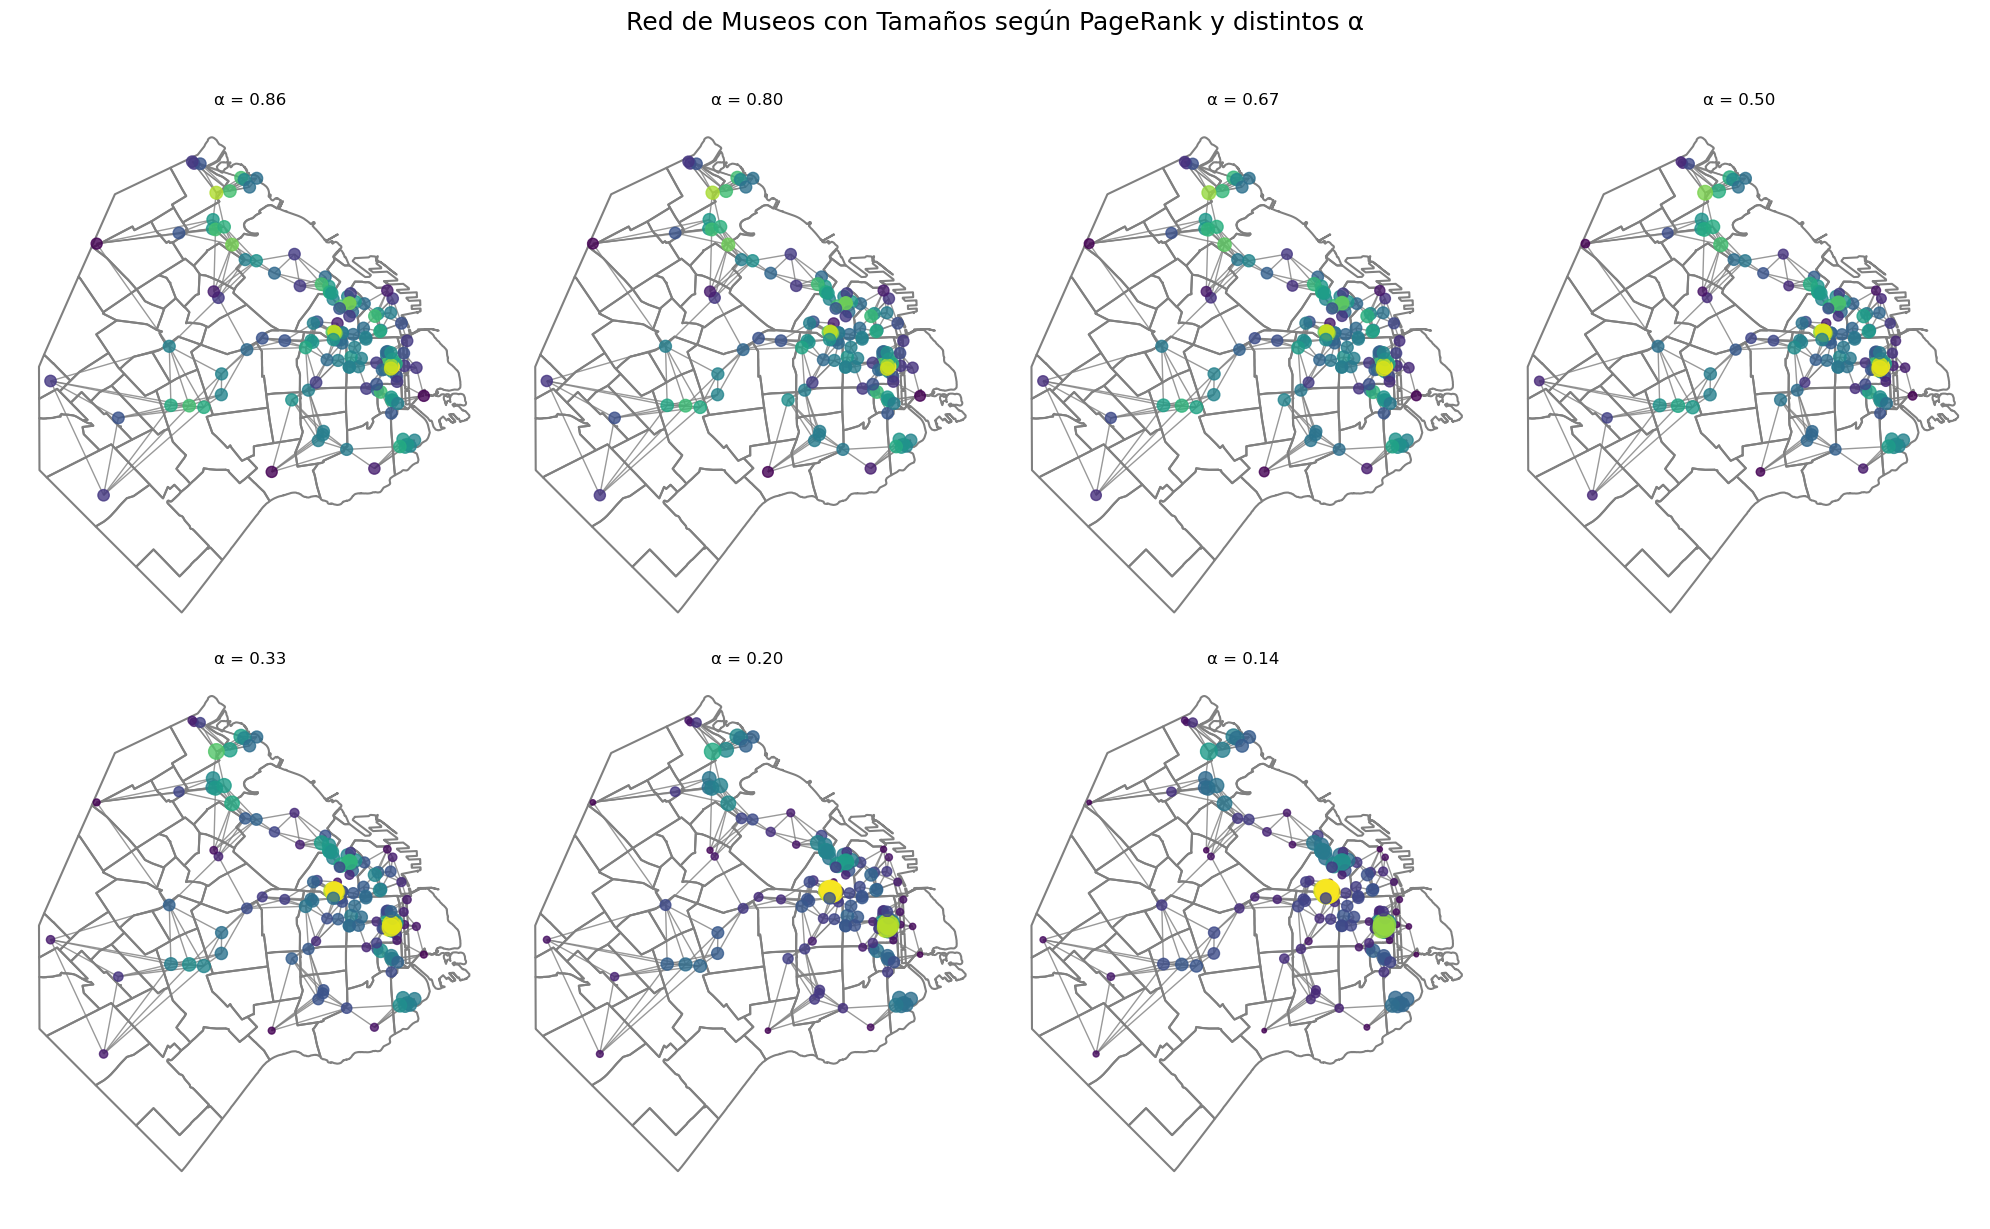

In [22]:
m = 5
rango_alpha = [6/7,4/5,2/3,1/2,1/3,1/5,1/7]
template_funciones.ejercicio_3_c(D, m,rango_alpha)

### 3a).2 Análisis del ranking

Usando los valores de $p$ obtenidos para cada caso, identificaremos los 3 museos más centrales (variando $m$ o $\alpha$) y graficaremos sus puntajes de Page Rank en función del parámetro que varía.

Analizaremos si las posiciones en el ranking son estables, y describiremos patrones relevantes.

Primero dejamos $\alpha = 1/5$ fijo y variamos $m$ obteniendo el siguiente grafico.

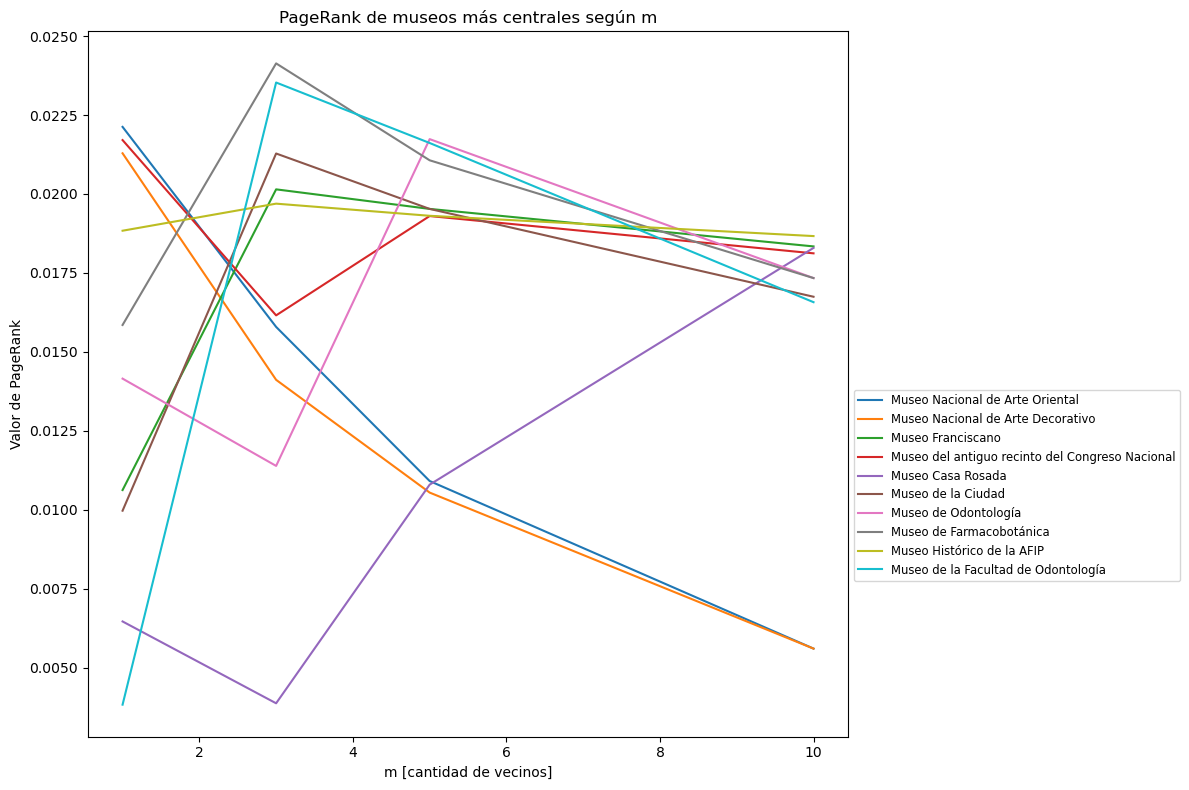

In [24]:
template_funciones.grafico_mayores_pg_variando_m(D, alpha, rango_m)

Algunos museos (como el Museo Nacional de Arte Oriental o el Museo Histórico de la AFIP) mantienen valores de PageRank relativamente altos y estables para diferentes valores de $m$. Esto sugiere que su importancia no depende mucho de la cantidad de conexiones, ya son relevantes en redes más chicas y siguen siéndolo en redes más grandes.
Tambien que al aumentar el $m$ aumenta PageRank (cómo Museo Casa Rosada), Esto podría indicar que se beneficia de estar más conectado, o que no era central en redes pequeñas pero sí lo es cuando se considera más contexto. Algunos museos, como el Museo Patricios, tienen valores que varían bastante cuando hacemos variar el $m$. Eso puede significar que su relevancia es sensible a la estructura de la red.
Además se puede ver que los museos que obtuvieron mayor PageRank fueron el Museo de Farmacobotanica para m = 3, el Museo de la Facultad de Odontologia para m = 3 y el Museo de Odontoligia para m = 5.



Para terminar el analisis dejamos  $m$= 5  fijo y variamos $\alpha$:

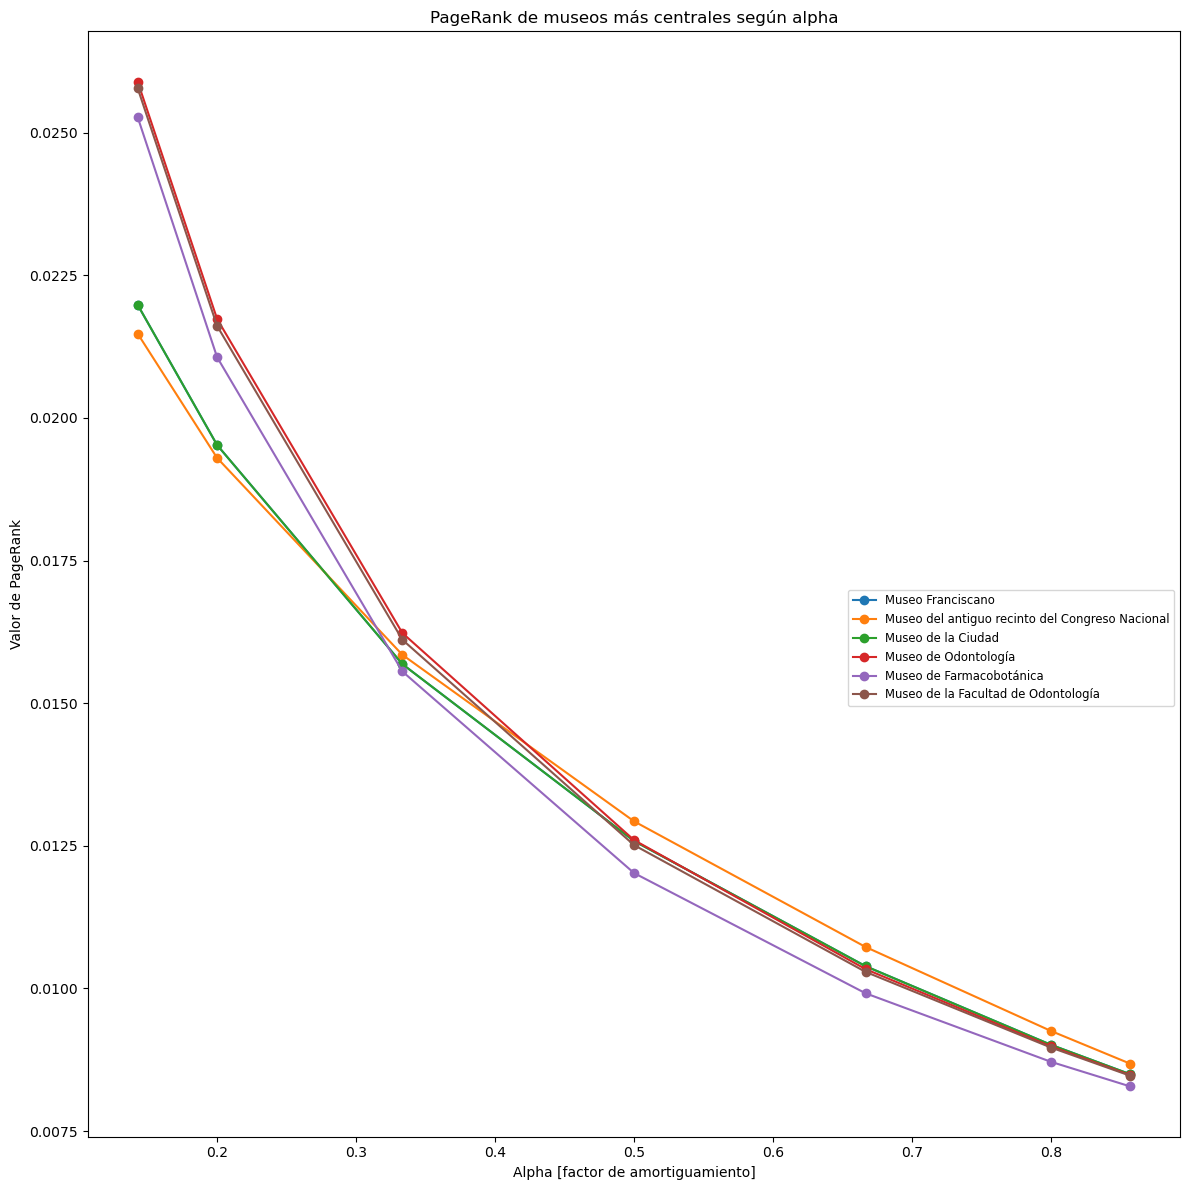

In [25]:
template_funciones.grafico_mayores_pg_variando_alpha(D, m,rango_alpha)

Analizando la trayectoria de los museos centrales según el rango de $\alpha$= 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7 y $m$=3.
A grandes rasgos se puede ver que para todos los museos a medida que el valor de $\alpha$ incrementa (disminuye la aleatoreidad) los valores de PageRank decrecen.
Además se puede observar que cuando $\alpha$ esta entre  1/7 y 1/3 hay mucha dispersión entre los PageRanks de los museos y a medida que $\alpha$ se acerca a 1 esta diferencia se achica.

Con un $\alpha$ bajo, algunos museos capturan mucho valor por su ubicación y los mas alejados quedan con muy poco puntaje.
Con un $\alpha$ alto la dispersión es menor y se favorecen los museos bien enlazados.

El PageRank se distribuye de forma más equitativa cuando los museos están bien conectados entre sí. Por ejemplo, si comparamos este gráfico con otro generado utilizando el mismo rango de valores para $\alpha$, pero con un valor de m=3, observamos que la dispersión de los valores de PageRank entre los museos es mucho mayor. Esto se debe a que, en ese caso, los nodos no están suficientemente enlazados, lo que genera una red menos cohesionada y con mayor desigualdad en la distribución de la centralidad.

Cabe destacar que los museos que mas veces fueron centrales para distintos $\alpha$ son el Museo de Odontologia,el Museo de la Facultad de Odontología y el Museo del antiguo recinto del Congreso Nacional.
Además los museos que obtuvieron un PageRank más alto fueron el Museo de Odontologia,el Museo de la Facultad de Odontología y el Museo de Farmacobotanica.

### 3b).2 Analizamos los graficos de los incisos 3b).1 y 3c).1
Al disminuir el $\alpha$ el pageRank de los museos que se encuentran en la periferia del mapa baja, y la zona noreste gana mayor relevancia. Con valores de $\alpha$ mas altos, tenemos menos dispersion entre nodos con pageRanks altos. Con $\alpha$ alto, el modelo depende más de la conectividad real de los nodos, por lo que los nodos más periféricos, que tienen pocas conexiones, se ven desfavorecidos. Es decir, al disminuir la aleatoriedad influye mucho más qué tan conectado está un museo a otros.


En cambio, cuando variamos el $m$ ocurre lo contrario. Con un $m$ chico ($m$=1) el mapa es muy disperso. No hay un centro de la red claramente definido. A medida que aumentamos el $m$, la red se vuelve mas densa. Y se nota un centro geográfico más activo en el noreste de la red. Esto ocurre porque esos nodos acumulan muchas conexiones y pasan a ser claves para el flujo de accesibilidad dentro de la red. Las regiones más conectadas del noreste se consolidan como predominantes (más grandes y amarillas), ya que reciben muchas conexiones y tienen más influencia dentro del grafo.

Se puede ver que para todo $\alpha$ los barrios que contienen a los museos con PageRank mas altos son Montserrat, Recoleta y Balvanera. Lo mismo ocurre para todo $m$ expecto cuando $m$ = 1 que barrios como La Boca, Parque Patricios, Flores y Belgrano cobran relevancia.



## Punto 4:
Suponiendo que cada persona realiza un número fijo de visitas
r antes de abandonar la red, y considerando que el recorrido de los visitantes se describe mediante la matriz de transición
C, es posible establecer una relación entre el vector de entradas v y el vector de visitas totales w.

\begin{align*}
v_0 &= C^0 \ast v_0  \rightarrow \text{entrada a la red} \\
v_1 &= C^1 \ast v_0  \rightarrow \text{distribución de museos luego de 1 paso} \\
\vdots \\
v_{r-1} &= C^{r-1} \ast v_0 \rightarrow \text{distribución de museos luego de r-1 } \text{ pasos} \\
\\
w &= v_0 + v_1 + \cdots + v_{r-1} \\
w &= C^0 \ast v_0 + C^1 \ast v_0 + \cdots + C^{r-1} \ast v_0 \\
w &= \left(\sum_{i=0}^{r-1} C^k\right) \ast v_0 \\
w &= B \ast v_0  \rightarrow  \text{de aca despejamos } v_0 \\ \therefore \boxed{v_0 = B^-1 \ast w}
\end{align*}

Demostramos que el vector de entradas $v$ puede estimarse como $v = B^{-1}w$, siendo $B = \sum_{k=0}^{r-1} C^k$. Esta relación permite reconstruir el origen de las visitas a partir del total observado, considerando el número fijo de pasos $r$ que cada visitante realiza en la red.


## Punto 5:

In [29]:
cant_pasos = 3
C = template_funciones.calcula_matriz_C_continua(D)
B = template_funciones.calcula_B(C, cant_pasos)
v = template_funciones.resolucion_eq_5(B)
print(f'Cantidad  total de visitantes= {v}')

Cantidad  total de visitantes= 136604.99999999997


Obtenemos el valor de $||v||_1$  que representa la cantidad total de visitantes que entraron en la red, a partir del vector $w$ provisto. \\
La cantidad total estimada de visitantes es aproximadamente $136604.99999999997$ Suponemos que el número obtenido no es entero debido a pequeños errores numéricos en su cálculo, aunque al representar una cantidad de personas debería no poseer decimales. Por lo tanto, aplicamos redondeo y concluimos que la cantidad total de visitantes es $136605$,  con un margen de error numérico aceptable.

## Punto 6:

In [35]:
cond = template_funciones.condicion_1(B)
print(f'El valor de la condición es= {cond}')


El valor de la condición es= 5.051771176665005


La matriz B  está  bastante bien condicionada. Obtuvimos un número de condición $ \text{cond}_1(B) \approx 5.052 $. Esto significa que alteraciones en el vector $w$ (que representa las visitas registradas por museo) no generan errores muy significativos en el cálculo del vector $v$(las visitas iniciales), el cual se determina mediante:

\begin{align*}
v = B^{-1} w
\end{align*}

A continuación, analizamos la cota para el error relativo en la estimación de $v$, utilizando la desigualdad planteada en el enunciado:

\begin{align*}
\frac{\|v - \hat{v}\|}{\|v\|} \leq \text{cond}_1(B) \cdot \frac{\|w - \hat{w}\|}{\|w\|}
\end{align*}

Asumimos un error relativo del 5\% en los datos del vector $w$:

\begin{align*}
\frac{\|w - \hat{w}\|}{\|w\|} = 0.05
\end{align*}

Reemplazando en la fórmula, obtenemos:

\begin{align*}
\frac{\|v - \hat{v}\|}{\|v\|} \leq 5.052 \cdot 0.05 \approx 0.2526
\end{align*}

Este resultado indica que un error del 5\% en los datos de entrada podría generar un error relativo de hasta un 25.26\% en la solución. Aunque este valor no es despreciable, sigue siendo razonable considerando que estamos resolviendo un sistema con datos reales, donde cierta incertidumbre es esperable.

Cabe destacar que $B$ se construye como una suma de matrices de transición de múltiples pasos:

\begin{align*}
B = I + G + G^2 + \cdots + G^{r-1}
\end{align*}

Este tipo de acumulación puede amplificar ciertos errores si la matriz estuviese mal condicionada.



# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

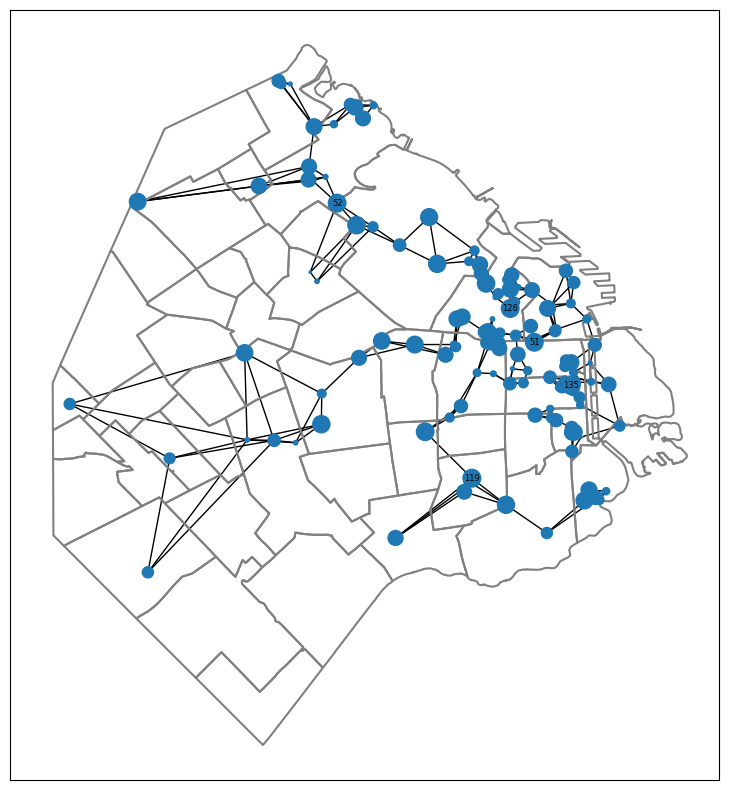

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres